In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pathlib

2023-01-21 21:46:35.354815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-21 21:46:35.452083: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-21 21:46:35.452097: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-21 21:46:35.938954: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
## Locates Image Dataset
data_dir = pathlib.Path('/home/erickillian/DataSets/people')
total_image_count = len(list(data_dir.glob('*/*')))
no_tattoos_dir = list(data_dir.glob('no_tattoos/*'))
tattoos_dir = list(data_dir.glob('tattoos/*'))

# Shows the total images and the relative image counts
for folder in data_dir.glob('*'):
    folder_name = folder.parts[-1]
    folder_dir = list(data_dir.glob(f"{folder_name}/*"))
    print(f"{folder_name}: {len(folder_dir)}")


print(f"Total Image Count: {total_image_count}")

tattoos: 1056
no_tattoos: 621
Total Image Count: 1677


In [3]:
def show_images(images, titles=None, rows=4, cols=10):
    figure, axis = plt.subplots(rows, cols)

    scale = 1.5
    figure.set_size_inches(cols*scale, rows*scale)
    images_length = len(images)

    plt.gca().clear()

    index = 0
    for i in range(rows):
        for j in range(cols):
            image = mpimg.imread(images[index])
            axis[i, j].axis('off')
            axis[i, j].imshow(image)
            # axis[i, j].set_title(f"{titles[index]}")
            index += 1
            if index >= images_length:
                return

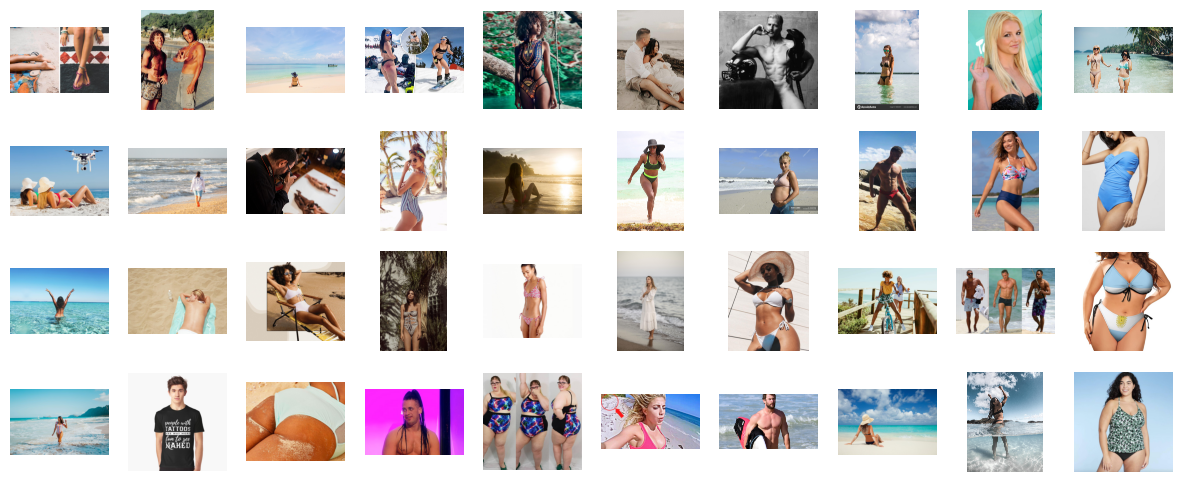

In [4]:
## Prints images of people without tattoos to prove data can be accessed
show_images(no_tattoos_dir)

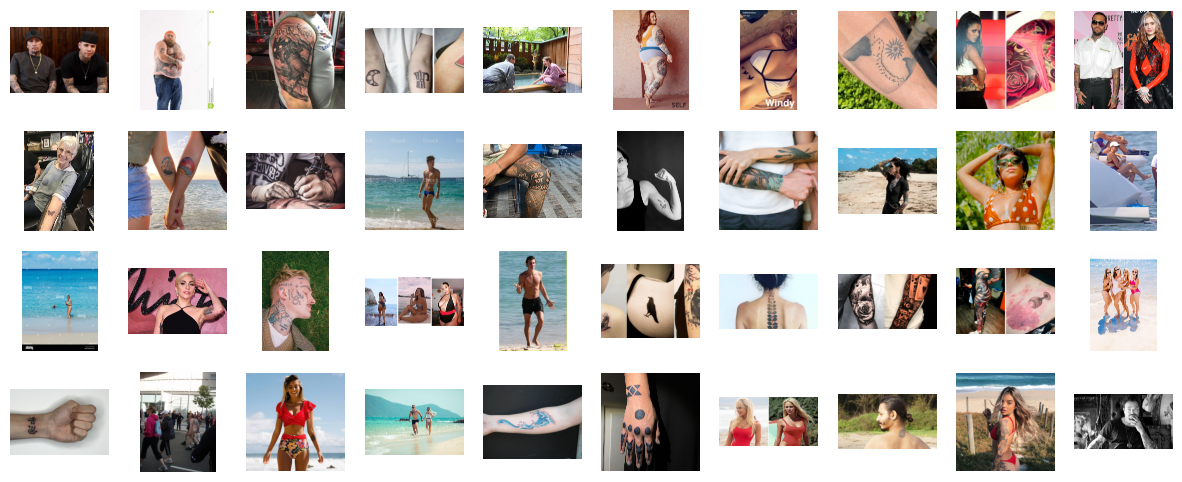

In [5]:
## Prints images of people without tattoos to prove data can be accessed
show_images(tattoos_dir)

In [6]:
BATCH_SIZE = 8
IMAGE_WIDTH = 400
IMAGE_HEIGHT = 400

In [7]:


@tf.function
def scale(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return (image, label)


@tf.function
def random_crop(images, labels):
    boxes = tf.random.uniform(shape=(len(images), 4))
    box_indices = tf.random.uniform(shape=(len(images),), minval=0, maxval=BATCH_SIZE, dtype=tf.int32)
    images = tf.image.crop_and_resize(images, boxes, box_indices, (2000,2000))
    return images, labels

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    crop_to_aspect_ratio=True,
    color_mode="rgb",
    label_mode="binary"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    crop_to_aspect_ratio=True,
    color_mode="rgb",
    label_mode="binary"
)


Found 1677 files belonging to 2 classes.
Using 1342 files for training.
Found 1677 files belonging to 2 classes.
Using 335 files for validation.


2023-01-21 21:46:49.285433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 21:46:49.285706: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-21 21:46:49.285751: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-21 21:46:49.285788: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-21 21:46:49.285824: W tensorflow/c

In [9]:
class_names = train_ds.class_names
print(class_names)

['no_tattoos', 'tattoos']


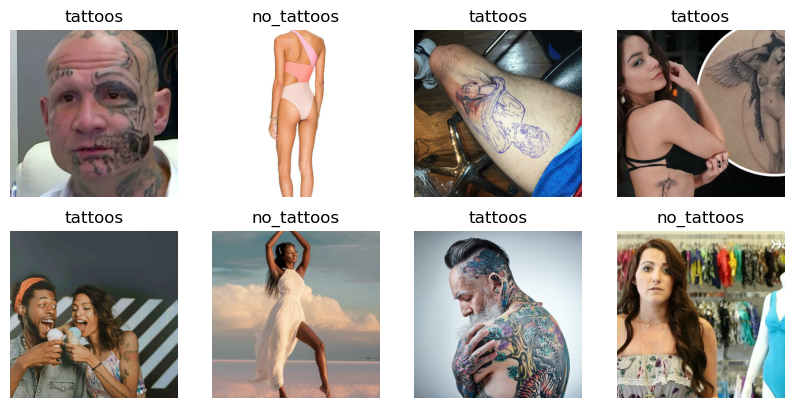

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(BATCH_SIZE):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i].numpy().astype('uint8')[0]])
    plt.axis("off")

In [11]:


model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2)
])

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [13]:
model.fit(train_ds, epochs=3)

Epoch 1/3


In [ ]:
test_loss, test_acc = model.evaluate(val_ds, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

42/42 [==============================] - 5s 110ms/step - loss: 0.6228 - sparse_categorical_accuracy: 0.6687
Test loss: 0.6227722764015198
Test accuracy: 0.6686567068099976


In [ ]:
# test_predictions = np.argmax(model.predict(test_images), axis=1)